In [1]:
# prompt: Connect to my google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import types
import sys

class FxNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.batchNorm1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.batchNorm2 = nn.BatchNorm2d(12)
        self.fc1 = nn.Linear(12*29*18, 120)
        self.batchNorm3 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 60)
        self.batchNorm4 = nn.BatchNorm1d(60)
        self.out = nn.Linear(60, self.n_classes)

    def forward(self, t):
        t = self.conv1(t)
        t = self.batchNorm1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, 2, 2)
        t = self.conv2(t)
        t = self.batchNorm2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, 2, 2)
        t = t.view(-1, 12*29*18)
        t = self.fc1(t)
        t = self.batchNorm3(t)
        t = F.relu(t)
        t = self.fc2(t)
        t = self.batchNorm4(t)
        t = F.relu(t)
        t = self.out(t)
        return t

# Step 2: Dynamically create the module hierarchy: model.models.FxNet
model_module = types.ModuleType("model")
models_submodule = types.ModuleType("model.models")
setattr(models_submodule, "FxNet", FxNet)
setattr(model_module, "models", models_submodule)

# Step 3: Inject into sys.modules
sys.modules["model"] = model_module
sys.modules["model.models"] = models_submodule

# Step 4: Load model
model_path = "/content/drive/MyDrive/PedalML/fx_classifier_models/20201211_fxnet_poly_disc_noTS9_best"
# model_path = "/content/drive/MyDrive/PedalML/fx_classifier_models/20201027_fxnet_poly_disc_best"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fxnet_model = torch.load(model_path, map_location=device, weights_only=False)
fxnet_model.eval()


FxNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (batchNorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (batchNorm2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=6264, out_features=120, bias=True)
  (batchNorm3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (batchNorm4): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=60, out_features=12, bias=True)
)

In [30]:
class CausalConv1d(nn.Module):
    """1D convolution with causal padding (pad on the left only)."""
    def __init__(self, in_channels, out_channels, kernel_size=2, dilation=1):
        super(CausalConv1d, self).__init__()
        self.dilation = dilation
        self.kernel_size = kernel_size
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size,
                               dilation=dilation)
        # No padding argument here; we will pad in forward for causality.

    def forward(self, x):
        # Pad input on the left (past) side only.
        pad_amount = (self.kernel_size - 1) * self.dilation
        if pad_amount > 0:
            # Pad format is (left_pad, right_pad) for 1D conv.
            x = F.pad(x, (pad_amount, 0))
        return self.conv(x)

class WaveNetModel(nn.Module):
    def __init__(self, residual_channels=32, skip_channels=32, dilation_layers=10):
        """
        WaveNet-style model.
        residual_channels: number of channels in residual convolution branches.
        skip_channels: number of channels for skip connections.
        dilation_layers: how many dilated conv layers (with dilation doubling each layer).
        """
        super(WaveNetModel, self).__init__()
        self.residual_channels = residual_channels
        self.skip_channels = skip_channels
        self.dilation_layers = dilation_layers

        # Initial 1x1 convolution to expand input from 1 channel to residual_channels.
        self.input_conv = nn.Conv1d(1, residual_channels, kernel_size=1)

        # Create lists for gated convolution layers
        self.filter_convs = nn.ModuleList()
        self.gate_convs = nn.ModuleList()
        self.residual_convs = nn.ModuleList()
        self.skip_convs   = nn.ModuleList()

        for i in range(dilation_layers):
            # Dilation doubles each layer: 1, 2, 4, ...
            dilation = 2 ** i
            # Causal conv for filter and gate
            self.filter_convs.append(CausalConv1d(residual_channels, residual_channels,
                                                  kernel_size=2, dilation=dilation))
            self.gate_convs.append(CausalConv1d(residual_channels, residual_channels,
                                                kernel_size=2, dilation=dilation))
            # 1x1 conv for residual connection
            self.residual_convs.append(nn.Conv1d(residual_channels, residual_channels, kernel_size=1))
            # 1x1 conv for skip connection (to accumulate outputs for final output)
            self.skip_convs.append(nn.Conv1d(residual_channels, skip_channels, kernel_size=1))

        # Final output layers: combine skip outputs and map to 1-channel audio output
        self.output_mixer = nn.Sequential(
            nn.ReLU(),
            nn.Conv1d(skip_channels, 1, kernel_size=1)
        )

    def forward(self, x):
        # x shape: (batch, 1, samples)
        x = self.input_conv(x)  # shape: (batch, residual_channels, samples)
        skip_sum = 0  # accumulate skip connections output
        for i in range(self.dilation_layers):
            # Gated convolution
            filt = torch.tanh(self.filter_convs[i](x))
            gate = torch.sigmoid(self.gate_convs[i](x))
            out = filt * gate  # element-wise gating

            # Skip connection output
            skip_out = self.skip_convs[i](out)    # shape: (batch, skip_channels, samples)
            if isinstance(skip_sum, int) or skip_sum is None:
                skip_sum = skip_out
            else:
                skip_sum = skip_sum + skip_out    # accumulate skip outputs

            # Residual connection to feed into next layer
            res = self.residual_convs[i](out)     # (batch, residual_channels, samples)
            x = x + res                           # add to input (residual connection)

        # Mix skip outputs and produce final output
        y = self.output_mixer(skip_sum)  # shape: (batch, 1, samples)
        return y


In [31]:
import torchaudio
from torch.utils.data import Dataset, DataLoader

class GuitarEffectsDataset(Dataset):
    def __init__(self, clean_files, effect_files, sample_rate=44100, segment_length=3.0):
        assert len(clean_files) == len(effect_files), "Mismatched number of files"
        self.clean_files = clean_files
        self.effect_files = effect_files
        self.target_sr = sample_rate
        self.segment_samples = int(sample_rate * segment_length)  # e.g., 3s segment

    def __len__(self):
        return len(self.clean_files)

    def __getitem__(self, idx):
        # Load clean and effected audio
        clean_wave, sr_c = torchaudio.load(self.clean_files[idx])
        effect_wave, sr_e = torchaudio.load(self.effect_files[idx])
        # If stereo, take only one channel (assuming [channel, time] format from torchaudio)
        clean_wave = clean_wave.mean(dim=0, keepdim=True)  # shape [1, samples]
        effect_wave = effect_wave.mean(dim=0, keepdim=True)
        # Resample if needed to target sample rate
        if sr_c != self.target_sr:
            clean_wave = torchaudio.functional.resample(clean_wave, sr_c, self.target_sr)
        if sr_e != self.target_sr:
            effect_wave = torchaudio.functional.resample(effect_wave, sr_e, self.target_sr)
        # Pad or truncate to segment_samples
        # If too long, truncate; if too short, pad with zeros at end.
        if clean_wave.size(1) > self.segment_samples:
            clean_wave = clean_wave[:, :self.segment_samples]
            effect_wave = effect_wave[:, :self.segment_samples]
        else:
            pad_amount = self.segment_samples - clean_wave.size(1)
            if pad_amount > 0:
                clean_wave = F.pad(clean_wave, (0, pad_amount))
                effect_wave = F.pad(effect_wave, (0, pad_amount))
        # Return waveforms as tensors (shape [1, L]) and ensure dtype float32
        return clean_wave.float(), effect_wave.float()


In [32]:
# Get clean and effected guitar dataset
from os import listdir
from os.path import isfile, join
clean_file_path = "/content/drive/MyDrive/PedalML/Input"
clean_files = [join(clean_file_path, f) for f in listdir(clean_file_path) if isfile(join(clean_file_path, f))]
# Guitar Set
print(len(clean_files))
print(clean_files[:5])

effect_file_path = "/content/drive/MyDrive/PedalML/Target/distortion_reverb"
effect_files = [join(effect_file_path, f) for f in listdir(effect_file_path) if isfile(join(effect_file_path, f))]
# Guitar Set
print(len(effect_files))
print(effect_files[:5])



138
['/content/drive/MyDrive/PedalML/Input/2-0.wav', '/content/drive/MyDrive/PedalML/Input/3-0.wav', '/content/drive/MyDrive/PedalML/Input/1-0.wav', '/content/drive/MyDrive/PedalML/Input/4-0.wav', '/content/drive/MyDrive/PedalML/Input/1-1.wav']
6
['/content/drive/MyDrive/PedalML/Target/distortion_reverb/1.wav', '/content/drive/MyDrive/PedalML/Target/distortion_reverb/2.wav', '/content/drive/MyDrive/PedalML/Target/distortion_reverb/3.wav', '/content/drive/MyDrive/PedalML/Target/distortion_reverb/4.wav', '/content/drive/MyDrive/PedalML/Target/distortion_reverb/5.wav']


In [33]:
def match_list_lengths(list1, list2):
    len1, len2 = len(list1), len(list2)
    if len1 == len2:
        return list1, list2
    elif len1 > len2:
        repeated_list2 = (list2 * (len1 // len2 + 1))[:len1]
        return list1, repeated_list2
    else:
        repeated_list1 = (list1 * (len2 // len1 + 1))[:len2]
        return repeated_list1, list2

# Repeat the shorter file to match the length of the longer file by repeating
clean_files, effect_files = match_list_lengths(clean_files, effect_files)
dataset = GuitarEffectsDataset(clean_files, effect_files, sample_rate=44100, segment_length=3.0)
loader = DataLoader(dataset, batch_size=8, shuffle=True)

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define a Mel-spectrogram transform (differentiable)
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=44100,       # sample rate of audio
    n_fft=1024,             # FFT size
    hop_length=256,         # hop size for STFT
    n_mels=128              # number of Mel frequency bands
).to(device)

In [35]:
# fxnet_model = ...  # assume this is loaded with pre-trained weights
print(fxnet_model.eval())  # set to evaluation mode (not training it)
# Freeze parameters
for param in fxnet_model.parameters():
    param.requires_grad = False

# # Modify fxnet_model to easily get fc2 outputs.
# # This depends on fxnet_model's implementation.
# # If fxnet_model.fc3 is the final classification layer and fxnet_model.fc2 is the penultimate,
# # we can remove the final layer:
# if hasattr(fxnet_model, 'fc3'):
#     fxnet_model.fc3 = nn.Identity()
# # Now, fxnet_model(mel) will output whatever was previously the input to fc3 (i.e., fc2's output).


FxNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (batchNorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (batchNorm2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=6264, out_features=120, bias=True)
  (batchNorm3): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (batchNorm4): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=60, out_features=12, bias=True)
)


In [36]:
import torch.nn.functional as F

# Pre-emphasis filter function
pre_emphasis_coef = 0.95 # As used in https://arxiv.org/pdf/1811.00334 and other previous works
def pre_emphasis(signal):
    # signal shape: (batch, samples) or (batch, 1, samples)
    # We will ensure it's 2D (batch, samples) for simplicity
    if signal.dim() == 3:
        # assume shape (batch, 1, L)
        signal = signal[:, 0, :]
    # Apply y[n] = x[n] - alpha * x[n-1]
    # Pad the beginning with zero for alignment (y[0] = x[0])
    y = signal.clone()
    y[:, 1:] = signal[:, 1:] - pre_emphasis_coef * signal[:, :-1]
    # y[:, 0] is left as signal[:,0] (we could also do y[:,0] = signal[:,0] for clarity)
    return y

In [37]:
# # Suppose we have:
# # clean_waveform: tensor (batch, 1, L)
# # target_waveform: tensor (batch, 1, L)
# # output_waveform: tensor (batch, 1, L) from the model
# # (These come from the DataLoader and model.forward)

# # 1. Spectral loss (with pre-emphasis filter)
# clean_pre = pre_emphasis(clean_waveform)
# output_pre = pre_emphasis(output_waveform)
# # Use mean squared error on the pre-emphasized signals
# spectral_loss = F.mse_loss(output_pre, clean_pre)

# # 2. Embedding loss (using fxnet_model's fc2 features)
# # Compute Mel-spectrograms for target and output
# mel_target = mel_transform(target_waveform)    # shape: (batch, n_mels, time_frames)
# mel_output = mel_transform(output_waveform)    # shape: (batch, n_mels, time_frames)
# # If fxnet_model expects a channel dimension (e.g., [batch, 1, n_mels, time]), add it
# if mel_target.dim() == 3:  # (batch, n_mels, time)
#     mel_target_in = mel_target.unsqueeze(1)    # (batch, 1, n_mels, time)
#     mel_output_in = mel_output.unsqueeze(1)    # same shape for output
# else:
#     mel_target_in = mel_target
#     mel_output_in = mel_output

# # Get embeddings from fxnet_model (assuming we adjusted it to output fc2 activations)
# emb_target = fxnet_model(mel_target_in)   # shape: (batch, embed_dim)
# emb_output = fxnet_model(mel_output_in)   # shape: (batch, embed_dim)
# # Compute L1 loss between embeddings
# embedding_loss = F.l1_loss(emb_output, emb_target)

# # Total loss
# loss = spectral_loss + embedding_loss


Epoch 30/30 - Total Loss: 229.6686, Spectral: 0.0007, Embedding: 229.6679


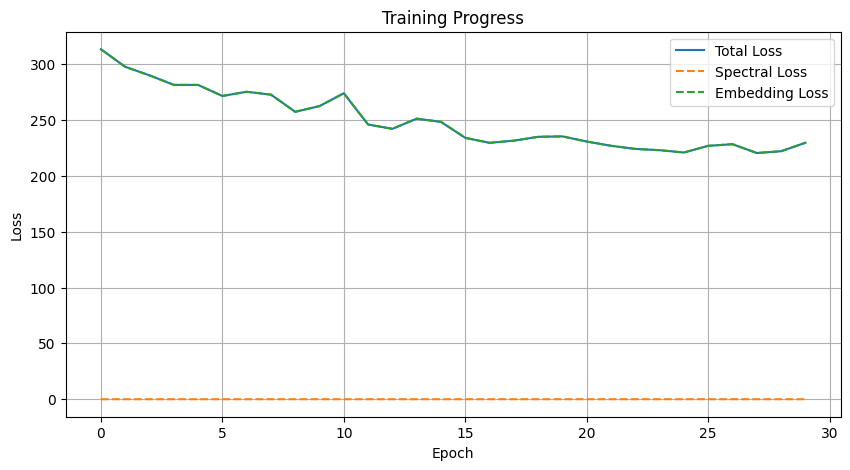

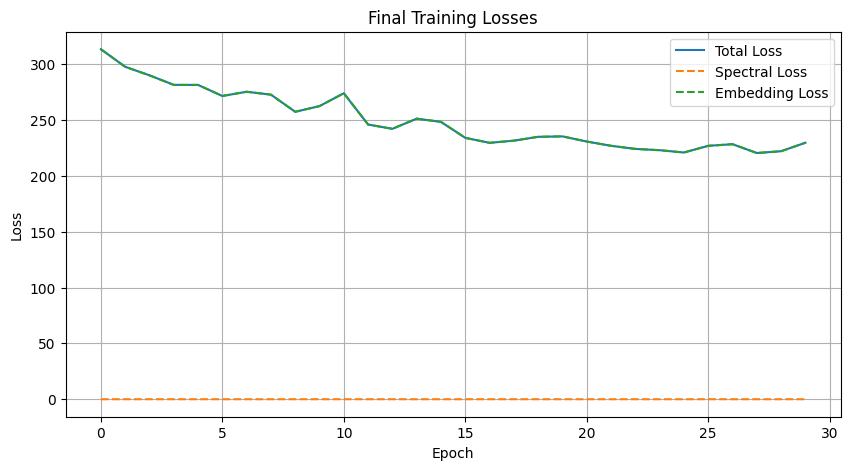

In [39]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Initialize model and optimizer
model = WaveNetModel(residual_channels=32, skip_channels=32, dilation_layers=10)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
fxnet_model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
model.train()
num_epochs = 30

# Lists to track loss
epoch_losses = []
spectral_losses = []
embedding_losses = []

for epoch in range(num_epochs):
    total_loss, total_spectral, total_embedding = 0.0, 0.0, 0.0

    for clean_wave, target_wave in loader:
        clean_wave = clean_wave.to(device)
        target_wave = target_wave.to(device)

        # Forward pass
        output_wave = model(clean_wave)

        # Spectral loss (pre-emphasized MSE)
        clean_pre = pre_emphasis(clean_wave)
        output_pre = pre_emphasis(output_wave)
        spectral_loss = F.mse_loss(output_pre, clean_pre)

        # Embedding loss (MAE in fxnet_model feature space)
        mel_target = mel_transform(target_wave)
        mel_output = mel_transform(output_wave)

        if mel_target.dim() == 3:
            mel_target = mel_target.unsqueeze(1)
            mel_output = mel_output.unsqueeze(1)

        with torch.no_grad():  # fxnet_model is frozen, no gradients needed
            emb_target = fxnet_model(mel_target)

        emb_output = fxnet_model(mel_output)
        embedding_loss = F.l1_loss(emb_output, emb_target)

        # Total loss
        loss = spectral_loss + embedding_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_spectral += spectral_loss.item()
        total_embedding += embedding_loss.item()

    # Average losses
    avg_loss = total_loss / len(loader)
    avg_spectral = total_spectral / len(loader)
    avg_embedding = total_embedding / len(loader)

    epoch_losses.append(avg_loss)
    spectral_losses.append(avg_spectral)
    embedding_losses.append(avg_embedding)

    clear_output(wait=True)
    print(f"Epoch {epoch+1}/{num_epochs} - Total Loss: {avg_loss:.4f}, "
          f"Spectral: {avg_spectral:.4f}, Embedding: {avg_embedding:.4f}")

    # Intermediate visualization every 5 epochs
    if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
        plt.figure(figsize=(10, 5))
        plt.plot(epoch_losses, label='Total Loss')
        plt.plot(spectral_losses, label='Spectral Loss', linestyle='--')
        plt.plot(embedding_losses, label='Embedding Loss', linestyle='--')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Progress')
        plt.legend()
        plt.grid()
        plt.show()

# Final results
plt.figure(figsize=(10, 5))
plt.plot(epoch_losses, label='Total Loss')
plt.plot(spectral_losses, label='Spectral Loss', linestyle='--')
plt.plot(embedding_losses, label='Embedding Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Final Training Losses')
plt.legend()
plt.grid()
plt.show()


In [40]:
import torch
import torchaudio
import torchaudio.transforms as T

model.to(device)
model.eval()

# Load audio file
def load_audio(file_path, target_sr=44100):
    waveform, sample_rate = torchaudio.load(file_path)
    if sample_rate != target_sr:
        resampler = T.Resample(sample_rate, target_sr)
        waveform = resampler(waveform)
    return waveform.to(device)

# Save audio file
def save_audio(file_path, waveform, sample_rate=44100):
    waveform_cpu = waveform.cpu().detach()
    torchaudio.save(file_path, waveform_cpu, sample_rate)

# Run inference on audio file
def process_audio(input_path, output_path):
    with torch.no_grad():
        input_wave = load_audio(input_path)  # shape: [1, L]
        input_wave = input_wave.unsqueeze(0)  # add batch dimension [1, 1, L]

        # Generate processed audio
        output_wave = model(input_wave)

        # Remove batch dimension
        output_wave = output_wave.squeeze(0)

        # Save output
        save_audio(output_path, output_wave)

# Example usage:
input_audio_file = "/content/drive/MyDrive/PedalML/Test/test.wav"
output_audio_file = "/content/drive/MyDrive/PedalML/Test/result.wav"

process_audio(input_audio_file, output_audio_file)

print(f"Audio processed and saved as '{output_audio_file}'.")


Audio processed and saved as '/content/drive/MyDrive/PedalML/Test/result.wav'.
